Este notebook es para la sistematizacion sin necesariamente usar un diccionario, solo para extraer ideas/palabras principales

In [14]:
import spacy
import pandas as pd
import numpy as np
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import textacy
from openpyxl import load_workbook
from openpyxl.drawing.image import Image

import funciones as f

In [15]:
nlp = spacy.load('es_core_news_md')

In [16]:
event = 'SRP3'
df = pd.read_excel('info.xlsx', sheet_name=event)

preguntas = ['P1', 'P2', 'P3']
expanded_responses = {}

In [17]:
def extract_nounphrases(x):
    doc = nlp(x)
    noun_phrases = list(textacy.extract.noun_chunks(doc, min_freq=1))
    unique_phrases = set()
    for phrase in noun_phrases:
        lower_phrase = phrase.text.lower()
        if not any(token.is_stop for token in phrase):
            unique_phrases.add(lower_phrase)
    return sorted(unique_phrases)

In [18]:
test_data = {}
for pregunta in preguntas:
    if pregunta in df.columns:
        test_data[pregunta] = df[['Sector', pregunta]].dropna()
        test_data[pregunta]['res'] = test_data[pregunta][pregunta].apply(extract_nounphrases)

In [19]:
#test_data

In [20]:
# Se obtienen las frecuencias de las palabras o frases que se extrajeron
frequency_data = {}

for pregunta, data in test_data.items():
    all_phrases = [phrase for phrases in data['res'] for phrase in phrases]
    
    phrase_counts = Counter(all_phrases)
    
    frequency_df = pd.DataFrame(phrase_counts.items(), columns=['Pregunta', 'Frecuencia'])
    frequency_df = frequency_df.sort_values(by='Frecuencia', ascending=False).reset_index(drop=True)
    
    frequency_data[pregunta] = frequency_df

In [21]:
#se obtienen los dataframes de las frecuencias de manera que se puedan graficar con la spidergraph
individual_dfs = {}

# Iterate through the frequency data for each question
for pregunta, freq_df in frequency_data.items():
    # Transpose the DataFrame and rename the index to the question name
    transposed_df = freq_df.set_index('Pregunta').T
    transposed_df.index = [pregunta]  # Set the index to the question name
    
    # Filter columns where the values are greater than 1
    filtered_transposed_df = transposed_df.loc[:, (transposed_df > 1).any()]
    
    # Add the filtered DataFrame to the dictionary
    individual_dfs[pregunta] = filtered_transposed_df.fillna(0)

df_p1 = individual_dfs['P1']
df_p2 = individual_dfs['P2']

c:\Users\shann\OneDrive\Documents\GitHub\sistematizacion_test\funciones.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values = np.append(values, values[0])
c:\Users\shann\OneDrive\Documents\GitHub\sistematizacion_test\funciones.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  values = np.append(values, values[0])


<Axes: title={'center': 'Resultados generales'}, ylabel='Pregunta'>

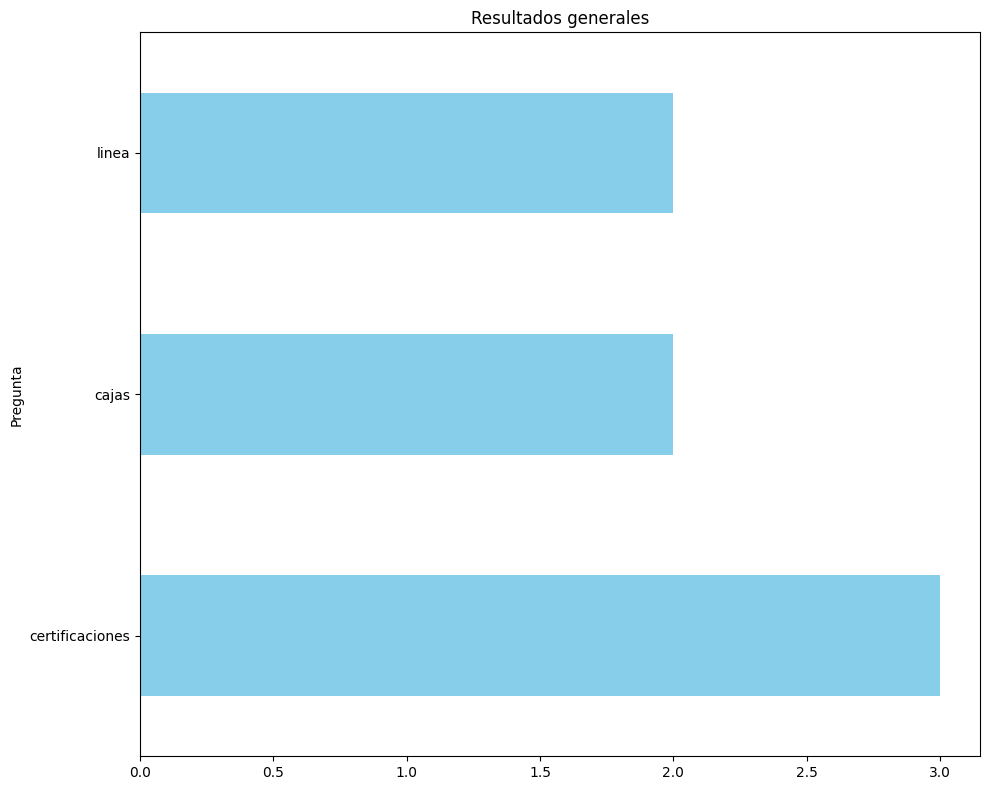

In [22]:
# se grafica usando la funcion que se definio en el archivo funciones.py
f.graf_rad(df_p1, 'res_nodict/graphs/P1_freq.png')
f.graf_rad(df_p2, 'res_nodict/graphs/P2_freq.png')
f.histograma(df_p1, 'res_nodict/graphs/P1_hist.png')

In [23]:
# se guarda la informacion en un archivo de excel
file_name = f'res_nodict/{event}.xlsx'
with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
    for pregunta, data in test_data.items():
        data.to_excel(writer, sheet_name=pregunta, index=False)
        
# Load the workbook to add images
wb = load_workbook(file_name)

# Add each image to its corresponding sheet
for pregunta in test_data.keys():
    sheet = wb[pregunta]  # Access the sheet for the current question
    image_file = f'res_nodict/graphs/{pregunta}_freq.png'  # Image file name for the question
    img = Image(image_file)  # Load the image
    img.anchor = 'H2'  # Position to insert the image (adjust as needed)
    sheet.add_image(img)  # Add the image to the sheet

# Save the workbook with the images included
wb.save(file_name)

In [24]:
file_name = f'res_nodict/resultados_frecuencia_{event}.xlsx'
with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
    for pregunta, freq_df in frequency_data.items():
        freq_df.to_excel(writer, sheet_name=f'{pregunta}_freq', index=False)